In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa, librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from google.colab import drive
drive.mount('/content/drive')


filen= open(os.path.join('/content/drive/My Drive/MIR/input/genres/input.txt'),'r');
filelist = [];
y_text = [];
y = [];

filen= os.path.join('/content/drive/My Drive/MIR/input/genres/input.txt');
with open(filen, 'r') as f:
    lines = f.read().split('\n')
    # print(lines)
for line in lines[:-1]:
    line = line.replace('/Users/sness/mirex2008', '/content/drive/My Drive/MIR/input').split('	')
    line_x = line[0];
    line_y = line[1];
    filelist.append(line_x);
    y_text.append(line_y.replace('\n',''));
    

# We do not need one-hot encoding. In that case, we can use an Identity matrix.
y_labels = {}
for i,j in enumerate(set(y_text)):
    y_labels[j] = i;
y_labels
# We encode labels using a numeric dictionary
for i in range(len(y_text)):
    y.append(y_labels[y_text[i]])

y = np.asarray(y);
clear_output()

# User generator


In [0]:
rand_seed = 1492;

# We compute all the features before we group them in vectors.
[file_train, file_test, y_train, y_test] = train_test_split(filelist, y, test_size=0.15, random_state = rand_seed, stratify = y)
# [file_train, file_val, y_train, y_val] = train_test_split(file_train, y_train, test_size=0.15, random_state = rand_seed, stratify = y_train)

In [0]:
def user_generator(user_file, files):
    user_aux = {};
    for i in user_file.keys():
        user_aux[i] = int(np.ceil(user_file[i]*n_files/100));

    user_counter = {'pop':0,'disco':0,'reggae':0,'country':0,'blues':0,'metal':0,'hiphop':0,'jazz':0,'classical':0,'rock':0}
    taste_list = [];
    for i in files:
        song_genre = i.split('/')[7];
        if user_counter[song_genre] < user_aux[song_genre]:
            np.random.seed(user_counter[song_genre])
            taste_list.append((i,
                               int(np.random.randint(10, 300, 1)[0]*np.sqrt(user_aux[song_genre]))
                               ))
            user_counter[song_genre]+=1;
    # print(user_counter)
    return taste_list

In [0]:
user_list = {}
n_random = 20;

for user_id in range(30):
    # np.random.seed(user_id*10000)
    file_train_random = random.sample(file_train, len(file_train));
    # np.random.seed(user_id*10000)
    n_files = np.random.randint(50,100+1,1)[0];
    # np.random.seed(user_id*10000)
    if user_id in np.arange(0,10):        
        user = {'pop':1+np.random.randint(n_random),'disco':1+np.random.randint(n_random),'reggae':1+np.random.randint(n_random),
                'country':1+np.random.randint(n_random),'blues':9+np.random.randint(n_random),'metal':1+np.random.randint(n_random),
                'hiphop':1+np.random.randint(n_random),'jazz':18+np.random.randint(n_random),'classical':66+np.random.randint(n_random),
                'rock':1+np.random.randint(n_random)}
    elif user_id in np.arange(10,20):
        user = {'pop':0+np.random.randint(n_random),'disco':0+np.random.randint(n_random),'reggae':0+np.random.randint(n_random),
                'country':0+np.random.randint(n_random),'blues':10+np.random.randint(n_random),'metal':40+np.random.randint(n_random),
                'hiphop':10+np.random.randint(n_random),'jazz':10+np.random.randint(n_random),'classical':0+np.random.randint(n_random),
                'rock':28+np.random.randint(n_random)}
    elif user_id in np.arange(20,30):
        user = {'pop':40+np.random.randint(n_random),'disco':30+np.random.randint(n_random),'reggae':0+np.random.randint(n_random),
                'country':0+np.random.randint(n_random),'blues':0+np.random.randint(n_random),'metal':0+np.random.randint(n_random),
                'hiphop':0+np.random.randint(n_random),'jazz':0+np.random.randint(n_random),'classical':0+np.random.randint(n_random),
                'rock':30+np.random.randint(n_random)}
    user_file_list = user_generator(user, file_train_random)
    user_list[str(user_id)] = {'user_file_list':user_file_list, 'user':user};

# Interaction matrices


In [0]:
# We create an emtpy interaction matrix
interaction_matrix = pd.DataFrame([], index = user_list.keys(), columns = file_train)
interaction_matrix.fillna(0, inplace=True)

# # We fill the content of the matrix using user data with the structure generated above.
for user_id in user_list.keys():
    for file_id in user_list[user_id]['user_file_list']:
        interaction_matrix.loc[user_id][file_id[0]]+=file_id[1]
# interaction_matrix.loc['0']
# interaction_matrix

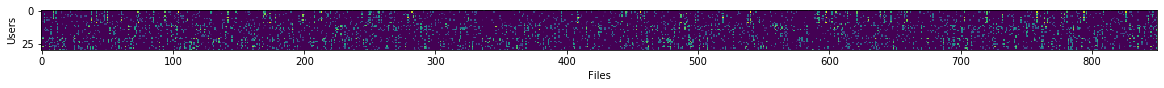

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(interaction_matrix);
plt.xlabel('Files');
plt.ylabel('Users');

# User-to-user recommender

In [0]:
np.random.seed(1991)
user = {'pop':40+np.random.randint(n_random),'disco':30+np.random.randint(n_random),'reggae':0+np.random.randint(n_random),
            'country':0+np.random.randint(n_random),'blues':0+np.random.randint(n_random),'metal':0+np.random.randint(n_random),
            'hiphop':0+np.random.randint(n_random),'jazz':0+np.random.randint(n_random),'classical':0+np.random.randint(n_random),
            'rock':30+np.random.randint(n_random)}
user_file_list = user_generator(user, file_train_random)

user_id = 'user'

user_vector = pd.DataFrame([], index = [user_id], columns = file_train)
user_vector.fillna(0, inplace=True)

for file_id in user_file_list:
    user_vector.loc[user_id][file_id[0]]+=file_id[1];

(30, 850) (1, 850)
Top-5 neighbors:[29 20 26 25 10]


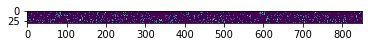

In [8]:
selected_user = '4';
from sklearn.neighbors import NearestNeighbors
def recommender_user2user(interaction_matrix, user_data):
    train_data = interaction_matrix;
    print(train_data.shape, user_data.shape)

    clf = NearestNeighbors();
    clf.fit(train_data)
    plt.imshow(train_data)
    
    out = clf.kneighbors(user_data)
    print('Top-5 neighbors:{}'.format(out[1][0]))

    '''
    We select the top neighbors and see which files they recommend. In order to do so, we normalize each of the user rows in the range [0,1],
    so in order to choose which song is the most popular we only need to use the sum operator in axis=0.
    '''
    neighbors_data = train_data.loc[[str(i) for i in(out[1][0])]];
    neighbors_data = neighbors_data/np.expand_dims(np.sum(neighbors_data, axis=1),axis=1)*np.ones((1,neighbors_data.shape[1]))
    recommendation_vector = np.sum(neighbors_data,axis=0);
    recommendation_vector.sort_values(inplace=True, ascending = False)
    #neighbors_data = neighbors_data/
    return recommendation_vector


recommendation_vector = recommender_user2user(interaction_matrix, user_vector)

In [110]:
# recommendation_vector = np.sum(aux,axis=0)
# recommendation_vector.sort_values(inplace=True, ascending = False)

# Songs that the user already has in his repo list.
known_songs = ((recommendation_vector > 0)*(user_vector > 0)*recommendation_vector).loc[user_id].sort_values(ascending = False)

# Songs that the user already has in his repo list.
new_songs = ((recommendation_vector > 0)*(user_vector == 0)*recommendation_vector).loc[user_id].sort_values(ascending = False)



KeyError: ignored

In [109]:
print('User preferences')
print(user)

print()
print('TOP-5 (SONGS YOU ALREADY KNOW):')
print('------------------------------------')
for i,j in known_songs[0:5].items():
    print('Song: {}. Score: {:.4f}'.format(i.split('/')[-1],j))

print()
print('TOP-5 (SONGS YOU SHOULD KNOW):')
print('------------------------------------')
for i,j in new_songs[0:5].items():
    print('Song: {}. Score: {:.4f}'.format(i.split('/')[-1],j))

User preferences
{'pop': 40, 'disco': 44, 'reggae': 19, 'country': 13, 'blues': 7, 'metal': 7, 'hiphop': 18, 'jazz': 5, 'classical': 11, 'rock': 32}

TOP-5 (SONGS YOU ALREADY KNOW):
------------------------------------


AttributeError: ignored

# Recommender item-2-item

In [0]:
selected_user = '4';
from sklearn.neighbors import NearestNeighbors
def recommender_item2item(train_data, user_data):
    print(train_data.shape, user_data.shape)

    # We get the favourite song of the user
    favourite_song = user_data.loc[user_id].argmax()
    item_vector = train_data[favourite_song]

    clf = NearestNeighbors(20);
    clf.fit(train_data.T)

    # We get the top-5 closest items.
    out = clf.kneighbors(np.expand_dims(item_vector,axis=0))
    
    print('Top-N neighbors:{}'.format(out[1][0]))

    '''
    We select the top neighbors and see which files they recommend. In order to do so, we normalize each of the user rows in the range [0,1],
    so in order to choose which song is the most popular we only need to use the sum operator in axis=0.
    '''
    neighbors_data = [(train_data.columns[j],i) for i,j in zip(out[0][0],out[1][0])]
    # neighbors_data = train_data.loc[[str(i) for i in(out[1][0])]];
    # neighbors_data = neighbors_data/np.expand_dims(np.sum(neighbors_data, axis=1),axis=1)*np.ones((1,neighbors_data.shape[1]))
    # recommendation_vector = np.sum(neighbors_data,axis=0);
    # recommendation_vector.sort_values(inplace=True, ascending = False)
    #neighbors_data = neighbors_data/
    return neighbors_data


recommendations = recommender_item2item(interaction_matrix, user_vector)


In [0]:
# # We get the favourite song of the user
# favourite_song = user_vector.loc[user_id].argmax()
# item_vector = interaction_matrix[favourite_song]

# clf = NearestNeighbors(20);
# clf.fit(interaction_matrix.T)

# # We get the top-5 closest items.
# out = clf.kneighbors(np.expand_dims(item_vector,axis=0))

The top-N recommendations of the system are the following ones

Notice that the first one is actually the favorite song of the user, which makes sense since it is the one with minimal distance respecting to itself. Consequently, we don't show it.

In [0]:
known_songs = [];
new_songs = [];
for i,j in recommendations[1:]:
    if user_vector.loc[user_id][i] > 0:
        known_songs.append((i,j));
    else:
        new_songs.append((i,j));
  


In [0]:
print('User preferences')
print(user)

print()
print('TOP-5 (SONGS YOU ALREADY KNOW):')
print('------------------------------------')
for i,j in known_songs[0:5]:
    print('Song: {}. Score (distance): {:.2f}'.format(i.split('/')[-1],j))

print()
print('TOP-5 (SONGS YOU SHOULD KNOW):')
print('------------------------------------')
for i,j in new_songs[0:5]:
    print('Song: {}. Score (distance): {:.2f}'.format(i.split('/')[-1],j))

In [0]:
i

In [0]:
def compute_features(x, feature_extraction):
    feat_vector = {};
    features = feature_extraction['features'];
    verbose = feature_extraction['verbose'];
    frame_length = feature_extraction['frame_length'];
    frame_hop = feature_extraction['frame_hop'];
    # We modify the length of the audio files so their maximum length is exactly of 30 seconds.
    x = x[0:29*sr];
    # We compute the spectrogram
    X = librosa.stft(x, n_fft=frame_length, hop_length = frame_hop, win_length = frame_length);

    if 'spectrogram' in features:
        if verbose == True:
            plt.figure(figsize = (20,5))
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
        
        if 'scaler_spectrogram' in feature_extraction.keys():
            scaler = feature_extraction['scaler_spectrogram'];
            X_spec = scaler.transform(np.abs(X).T);
        else:
            print('Creating new scaler', X.shape)
            scaler = StandardScaler();
            X_spec = scaler.fit_transform(np.abs(X).T);
            feature_extraction['scaler_spectrogram'] = scaler;
        feat_vector['spectrogram'] =  rectangle_feature(X_spec);


    if 'f_centroid' in features:
        spectral_centroid_X = librosa.feature.spectral_centroid(S = np.abs(X**2), sr = sr,
                                                                #n_fft = frame_length, hop_length = frame_hop, win_length = frame_length
                                                                );
        if verbose == True:
            plt.figure(figsize = (20, 10));
            plt.subplot(2,1,1);
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.subplot(2,1,2)
            plt.plot(np.arange(0, spectral_centroid_X.shape[1])/spectral_centroid_X.shape[1]*30, spectral_centroid_X.T);
            plt.title('Spectral centroid')
            plt.xlim([0, 30]);
            plt.ylabel('Freq (Hz)')
        # We normalize the spectral centroid using the maximum frequency available in the spectrogram.
        feat_vector['f_centroid'] = spectral_centroid_X/(sr/2);

    if 'mel' in features:    
        mel_X = librosa.feature.melspectrogram(S = np.abs(X**2), n_mels = 64, sr = sr);
        if verbose == True:
            plt.figure(figsize = (20, 10));
            plt.subplot(2,1,1);
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.subplot(2,1,2);
            librosa.display.specshow(librosa.amplitude_to_db(mel_X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'mel');
            plt.title('Mel-spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.tight_layout()
        
        mel_X = np.log(mel_X+1e-5)
        if 'scaler_mel' in feature_extraction.keys():
            scaler = feature_extraction['scaler_mel'];
            mel_X = scaler.transform(mel_X.T);
        else:
            print('Creating new scaler', mel_X.shape)
            scaler = StandardScaler();
            mel_X = scaler.fit_transform(mel_X.T);
            feature_extraction['scaler_mel'] = scaler;
        feat_vector['mel'] =  rectangle_feature(mel_X);

    if 'chroma_stft' in features:
        chroma_X = librosa.feature.chroma_stft(S = np.abs(X), sr= sr);
        if verbose == True:
            plt.figure(figsize = (20, 10));
            plt.subplot(2,1,1);
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.subplot(2,1,2)
            librosa.display.specshow(librosa.amplitude_to_db(chroma_X), sr = sr, hop_length = frame_hop, x_axis = 'time', y_axis = 'chroma')
            plt.title('Chromagram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.tight_layout()


        if 'scaler_chroma_stft' in feature_extraction.keys():
            scaler = feature_extraction['scaler_chroma_stft'];
            chroma_X = scaler.transform(chroma_X.T);
        else:
            print('Creating new scaler', chroma_X.shape)
            scaler = StandardScaler();
            chroma_X = scaler.fit_transform(chroma_X.T);
            feature_extraction['scaler_chroma_stft'] = scaler;
        feat_vector['chroma_stft'] = rectangle_feature(chroma_X);



    if 'mfcc' in features:
        mfcc_X = librosa.feature.mfcc(x, sr = sr, n_mfcc = 13, dct_type = 2, n_fft = frame_length, hop_length = frame_hop);
        if verbose == True:
            plt.figure(figsize = (20, 10));
            plt.subplot(2,1,1);
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.subplot(2,1,2)
            librosa.display.specshow(librosa.amplitude_to_db(mfcc_X),sr = sr, hop_length = frame_hop, x_axis  = 'time');
            plt.title('MFCC #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.tight_layout()
        if 'scaler_mfcc' in feature_extraction.keys():
            scaler = feature_extraction['scaler_mfcc'];
            mfcc_X = scaler.transform(mfcc_X.T);
        else:
            print('Creating new scaler', mfcc_X.shape)
            scaler = StandardScaler();
            mfcc_X = scaler.fit_transform(mfcc_X.T);
            feature_extraction['scaler_mfcc'] = scaler;
        feat_vector['mfcc'] = rectangle_feature(mfcc_X);
    

    if 'mfcc_delta' in features:
        mfcc_X = librosa.feature.mfcc(x, sr = sr, n_mfcc = 13, dct_type = 2, n_fft = frame_length, hop_length = frame_hop);
        mfcc_delta = librosa.feature.delta(mfcc_X)
        mfcc_delta2 = librosa.feature.delta(mfcc_X, order=2)
        out = np.vstack((mfcc_X, mfcc_delta, mfcc_delta2));

        if 'scaler_mfcc_delta' in feature_extraction.keys():
            scaler = feature_extraction['scaler_mfcc_delta'];
            out = scaler.transform(out.T);
        else:
            print('Creating new scaler', out.shape)
            scaler = StandardScaler();
            out = scaler.fit_transform(out.T);
            feature_extraction['scaler_mfcc_delta'] = scaler;

        feat_vector['mfcc_delta'] = rectangle_feature(out);

    if 'spectral_bw' in features:
        spectral_bw_X = librosa.feature.spectral_bandwidth(S = np.abs(X), sr = sr);
        if verbose == True:
            plt.figure(figsize = (20, 10));
            plt.subplot(2,1,1);
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.subplot(2,1,2)
            plt.plot(np.arange(0, spectral_bw_X.shape[1])/spectral_bw_X.shape[1]*30, spectral_bw_X.T);
            plt.title('Spectral bandwidth')
            plt.xlim([0, 30]);
            plt.ylabel('Freq (Hz)')

        # We normalize the spectral bandwidth using the maximum frequency available in the spectrogram.
        feat_vector['spectral_bw'] = spectral_bw_X/(sr/2);

    if 'pitch' in features:
        pitches, magnitudes = librosa.piptrack(S = np.abs(X), sr = sr);
        if verbose == True:
            plt.figure(figsize = (20, 10));
            plt.subplot(3,1,1);
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.subplot(3,1,2)
            librosa.display.specshow(pitches, x_axis = 'time', y_axis = 'hz',sr = sr, hop_length = frame_hop)
            plt.title('Pitches')
            plt.subplot(3,1,3)
            librosa.display.specshow(magnitudes, x_axis = 'time', y_axis = 'hz',sr = sr, hop_length = frame_hop)
            plt.title('Magnitudes')
            plt.tight_layout()
        
        # temp = (pitches*magnitudes)!=0;
        # pitch_hist = np.sum(temp, axis = 1)/np.sum(temp);

        pitch_vector = [];
        for t in range(pitches.shape[1]):
            pitch_vector.append(pitches[magnitudes[:,t].argmax(),t])
        feat_vector['pitch'] = pitch_vector;
        # feat_vector['pitch_freq'] = pitches;
        # feat_vector['pitch_mag'] = magnitudes;
        # feat_vector['pitch'] = pitch_hist;

    if 'f_flatness' in features: 
        spectral_flat_X = librosa.feature.spectral_flatness(S = np.abs(X), n_fft = frame_length);
        if verbose == True:
            plt.figure(figsize = (20, 10));
            plt.subplot(2,1,1);
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.subplot(2,1,2)
            plt.plot(np.arange(0, spectral_flat_X.shape[1])/spectral_flat_X.shape[1]*30, spectral_flat_X.T);
            plt.title('Spectral bandwidth')
            plt.xlim([0, 30]);
            plt.ylabel('Freq (Hz)')

        feat_vector['f_flatness'] = spectral_flat_X;


    if 'f_rolloff' in features:
        spectral_rolloff_X = librosa.feature.spectral_rolloff(S = np.abs(X), sr = sr);
        if verbose == True:
            plt.figure(figsize = (20, 10));
            plt.subplot(2,1,1);
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.subplot(2,1,2)
            plt.plot(np.arange(0, spectral_rolloff_X.shape[1])/spectral_rolloff_X.shape[1]*30, spectral_rolloff_X.T);
            plt.title('Spectral bandwidth')
            plt.xlim([0, 30]);
            plt.ylabel('Freq (Hz)')

        feat_vector['f_rolloff'] = spectral_rolloff_X/(sr/2);

    
    if 'tempo' in features: 
        tempo = librosa.beat.tempo(x, sr=sr);
        if verbose == True:            
            plt.figure(figsize = (20, 10));
            T = len(x)/float(sr)
            seconds_per_beat = 60.0/tempo[0]
            beat_times = np.arange(0, T, seconds_per_beat)
            plt.figure(figsize = (20,5))
            librosa.display.waveplot(x)
            plt.vlines(beat_times, -1, 1, color='r')
        
        tempo /= 60.0; #  bits per second
        out = np.zeros(shape=(3,));
        out[0] = tempo;
        out[1] = tempo/sr;
        out[2] = 1/tempo;
        feat_vector['tempo'] = out;

    if 'spectral_contrast' in features:
        feat = librosa.feature.spectral_contrast(S =  np.abs(X), sr = sr);
        if verbose == True:
            plt.figure(figsize = (20, 10));
            plt.subplot(2,1,1);
            librosa.display.specshow(librosa.amplitude_to_db(X), sr = sr, hop_length = frame_hop, x_axis = 'time',y_axis = 'linear');
            plt.title('Spectrogram #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.subplot(2,1,2)
            librosa.display.specshow((feat),sr = sr, hop_length = frame_hop, x_axis  = 'time');
            plt.title('Spectral contrast #{0}'.format(i));
            plt.xlabel('Time (s)');
            plt.ylabel('Frecuency bands')
            plt.tight_layout()    
        
        if 'scaler_spectral_contrast' in feature_extraction.keys():
            scaler = feature_extraction['scaler_spectral_contrast'];
            feat = scaler.transform(feat.T);
        else:
            print('Creating new scaler', feat.shape)
            scaler = StandardScaler();
            feat = scaler.fit_transform(feat.T);
            feature_extraction['scaler_spectral_contrast'] = scaler;
        feat_vector['spectral_contrast'] = rectangle_feature(feat);

    if 'vggish' in features:
        feat_vector['vggish'] = ProcessWithVGGish(vgg, x, sr);
    # return concatenate_features(feat_vector), concatenate_features(feat_vector).shape, feat_vector
    return feat_vector




def concatenate_features(x_feat_structure, feature_extraction):
    '''
    This function is in charge of concatenating a set of features that are pre-
    computed and listed in 'x_feat_structure' with their corresponding names.
    It returns a single column that contains all the features.
    '''
    x_feat_matrix = [];
    for i in feature_extraction['features']:#x_feat_structure.keys():
        x_feat_matrix.append(x_feat_structure[i]);
    return np.hstack(x_feat_matrix)


def load_signal(filename, feature_extraction):
    '''
    Function that reads an audio file 'filename' and extracts the features 
    according to the dictionary 'feature_extraction'. It returns the concatenated 
    features, producing a single vector for each audio file.
    '''
    audio = librosa.load(filename)[0];
    feat_dict = compute_features(audio, feature_extraction);
    #return features.T, feat_len[1]
    #return rectangle_feature(features.T)
    
    
    #return concatenate_features(feat_dict, feature_extraction)
    return feat_dict

def rectangle_feature(feature):
    '''
    Function designed to compute the average and the std from the input feature.
    '''
    feature_out = [];
    feature_out.append(np.mean(feature, axis = 0));
    feature_out.append(np.std(feature, axis = 0));
    return np.concatenate(feature_out,axis=0)



def plot_confusion_matrix(data_cm, data_labels):
    # plot_confusion_matrix(cm, y_labels)
    ''' 
    Function designed to plot a confusion matrix using seaborn. The inputs are
    the confusion matrix as a pandas Dataframe and a dictionary with the labels.
    '''
    # plt.figure(figsize=(8,6));
    ax = sn.heatmap(data_cm, yticklabels=data_labels.keys(), annot = True);
    ax.set_ylim(10, 0)
    ax.set_xticklabels(data_labels.keys(),rotation=45, horizontalalignment='right');


def classifiers(classifier_name, seed):
    random.seed(seed)
    if classifier_name == 'rforest':
        clf = RandomForestClassifier(random_state = seed);        
        param_dist = {
            'n_estimators':[random.randint(1,200) for i in range(n_iter_search)],  
            'max_depth':[random.randint(1,5) for i in range(n_iter_search-1)]+[None], 
            'min_samples_split':[random.randint(2,10) for i in range(n_iter_search)],
            'min_samples_leaf':[random.randint(1,5) for i in range(n_iter_search)],
            }
    if classifier_name == 'gboost':
        # Gradient boost
        clf = GradientBoostingClassifier(random_state=seed)
        param_dist = {
              'n_estimators':[random.randint(1,100) for i in range(n_iter_search)],  
              'max_depth':[random.randint(1,5) for i in range(n_iter_search-1)]+[None], 
              'min_samples_split':[random.randint(2,10) for i in range(n_iter_search)],
              'min_samples_leaf':[random.randint(1,5) for i in range(n_iter_search)],
              'learning_rate':[10**random.randint(-5,-1) for i in range(n_iter_search)],
              # 'subsample':[random.randint(1,4)/4 for i in range(n_iter_search)], 
              'max_features':[random.randint(1,4)/4 for i in range(n_iter_search)], 
              }

    if classifier_name == 'SVM':
        base_estim = SVC(random_state=seed);
        clf =OneVsRestClassifier(base_estim);
        param_dist = {
              'estimator__C':[10**random.randint(-5,0) for i in range(n_iter_search)], 
              'estimator__gamma':[10**random.randint(-5,2) for i in range(n_iter_search)], 
              }

    return clf, param_dist


# spectrogram, 'f_centroid','mel','chroma_stft','mfcc','spectral_bw','pitch','f_flatness', 'f_rolloff','poly'
combos = {
          'mf_tem_fcont': ['tempo','spectral_contrast'],
          }
# MFCC: general feature that allows to observe spectral properties from the signal along time. 
# Tempo: Helps to determine the 'tempo' of the musical piece. We measure the tempo in bps, the normalized tempo (divided by sr) and 1/tempo.
# Pitch: Produces a histogram showing the dominant frequencies of the piece.
# Spectral contrast: It is useful to discern, considering different subbands, if a component is noisy or narrowband.


In [16]:

# Common parameters
sr = 22050;
window_length =  int(200e-3*sr); # 100ms -> 100e-3*sr
feature_extraction = {}
feature_extraction['verbose'] = False;
feature_extraction['frame_length'] = window_length;
feature_extraction['frame_hop'] = int(window_length/2);
#feature_extraction['features'] = ['mfcc','tempo', 'mfcc_delta', 'spectral_contrast','vggish'];
feature_extraction['features'] = ['tempo', 'spectral_contrast'];
# feature_extraction['features'] = ['vggish'];


rand_seed = 1492;

# We compute all the features before we group them in vectors.
# [file_train, file_test, y_train, y_test] = train_test_split(filelist, y, test_size=0.85, random_state = rand_seed, stratify = y)
# [file_train, file_val, y_train, y_val] = train_test_split(file_train, y_train, test_size=0.15, random_state = rand_seed, stratify = y_train)
# [file_train, file_test, y_train, y_test] = train_test_split([filelist[i] for i in [0,1,100,101, 200,201, 300,301, 400,401]],
#                                                             [y[i] for i in [0,1,100,101, 200,201, 300,301, 400,401]],
#                                                             test_size=0.2, random_state = rand_seed, 
#                                                             )
data_train = [(file_train[i], load_signal(file_train[i],feature_extraction)) for i in range(len(file_train))];
data_test = [(file_test[i], load_signal(file_test[i],feature_extraction)) for i in range(len(file_test))];
# data_val = [(file_val[i],load_signal(file_val[i],feature_extraction)) for i in range(len(file_val))];


Creating new scaler (7, 291)


In [0]:
# data_test = [(file_test[i], load_signal(file_test[i],feature_extraction)) for i in range(len(file_test))];

In [19]:
data_train[0]

('/content/drive/My Drive/MIR/input/genres/country/country.00062.wav',
 {'spectral_contrast': array([ 1.61764454e-16,  3.84572099e-16, -6.40953499e-16,  1.22086381e-16,
         -1.46503657e-16, -2.68590038e-16,  5.43284394e-16,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00]),
  'tempo': array([1.48504849e+00, 6.73491379e-05, 6.73378685e-01])})

In [0]:
# MANTENER UN FICHERO DE HELDOUT PARA EVALUAR FUERA DEL ALCANCE DE LOS ALUMNOS.
del x_train

In [20]:
scores = {};
params = {};
confusion_matrices = {};
reports = {};
n_iter_search = 10

x_train = {}
x_test = {}
for combo_i in combos.keys():
  # We reset the feature_extraction vector every time so the scaler disappears.
  print('Processing combo: {0}'.format(combos[combo_i]))
  feature_extraction['features'] = combos[combo_i];

  # Here, we group the pre-computed features.
  for i in data_train:
    x_train[i[0]] = concatenate_features(i[1], feature_extraction);
  for i in data_test:
    x_test[i[0]] = concatenate_features(i[1], feature_extraction);
  # x_train_list = [i[0] for i in data_train];
  # x_test = [concatenate_features(i, feature_extraction) for i in data_test];

  # specify parameters and distributions to sample from
  # random.seed(rand_seed)
  
  # for clf_name in ['gboost']:
  #     clf, param_dist = classifiers(clf_name, rand_seed)

  #     random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False, n_jobs = 2, scoring = 'accuracy', random_state=rand_seed, verbose = False);
  #     random_search.fit(x_train, y_train);    

  #     params[clf_name+'+'+combo_i] = random_search.best_params_
  #     scores[clf_name+'+'+combo_i] = random_search.best_score_
  #     y_pred = random_search.best_estimator_.predict(x_test);

  #     # Confusion matrix
  #     cm = pd.DataFrame(confusion_matrix(y_test, y_pred));
  #     cm.index.name = 'Actual';
  #     cm.columns.name = 'Predicted';
  #     confusion_matrices[clf_name+'+'+combo_i] = cm;

  #     # F-score/Accuracy report
  #     reports[clf_name+'+'+combo_i] = classification_report(y_test, y_pred, target_names= y_labels.keys(),output_dict=True);


Processing combo: ['tempo', 'spectral_contrast']


In [0]:
# We extract a round score for each song
def get_user_data(user_data):
    # user_data = user_vector.loc['user']
    interaction_matrix_stars = pd.Series(0,index = user_data.index)

    song_reps = user_data[user_data> 0];
    song_stars = np.round(song_reps/np.max(song_reps)*4)+1;
    x_train_user = [x_train[i] for i in song_reps.keys()];
    y_train_user = [int(i) for i in song_stars];

    interaction_matrix_stars[song_stars.keys()] = song_stars
    #print(np.round(user_data/np.max(user_data)*4)+1)
    # if len(im_stars) > 0:
    #     for i
    return x_train_user, y_train_user, interaction_matrix_stars

# x_train_temp, y_train_temp, interaction_matrix_stars = get_user_data(user_vector.loc['user'])


In [0]:
# interaction_matrix_stars



# Supervised classification




In [0]:
from sklearn.ensemble import RandomForestClassifier

# user_id = '0'

clf_list = {}
star_list = {}
# Interaction matrix
for user_id in interaction_matrix.index:
  x_train_temp, y_train_temp, interaction_stars = get_user_data(interaction_matrix.loc[user_id]);
  clf = RandomForestClassifier(n_estimators = 10)
  clf.fit(x_train_temp, y_train_temp)
  clf_list[user_id] = clf;

  for i in interaction_stars.keys():
      if interaction_stars[i] == 0:
          interaction_stars[i] = clf.predict(np.expand_dims(x_train[i], axis=0));
      else:
          interaction_stars[i] = interaction_stars[i]

  star_list[user_id] = interaction_stars
  del interaction_stars

# y_train_temp

/content/drive/My Drive/MIR/input/genres/country/country.00062.wav        False
/content/drive/My Drive/MIR/input/genres/disco/disco.00009.wav            False
/content/drive/My Drive/MIR/input/genres/classical/classical.00077.wav    False
/content/drive/My Drive/MIR/input/genres/reggae/reggae.00004.wav          False
/content/drive/My Drive/MIR/input/genres/country/country.00032.wav        False
                                                                          ...  
/content/drive/My Drive/MIR/input/genres/rock/rock.00052.wav              False
/content/drive/My Drive/MIR/input/genres/classical/classical.00085.wav    False
/content/drive/My Drive/MIR/input/genres/jazz/jazz.00086.wav              False
/content/drive/My Drive/MIR/input/genres/blues/blues.00012.wav            False
/content/drive/My Drive/MIR/input/genres/rock/rock.00006.wav              False
Length: 850, dtype: bool

In [180]:
# USER CLASSIFIER
x_train_temp, y_train_temp, user_stars = get_user_data(user_vector.loc['user'])

clf = RandomForestClassifier(n_estimators = 10)
clf.fit(x_train_temp, y_train_temp)

user_unknown = pd.Series();
for i in user_stars.keys():
      if user_stars[i] == 0:
        # These are the NEW recommendations from the system.
          user_stars[i] = clf.predict(np.expand_dims(x_train[i], axis=0));
          user_unknown[i] = user_stars[i]
      else:
          user_stars[i] = user_stars[i]
# # User train-data confusion matrix
# y_pred = clf.predict(x_train_temp)
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_train_temp, y_pred)

print('Predicted stars: ')
user_unknown.value_counts()

Predicted stars: 


3.0    393
2.0    252
4.0     41
1.0     23
5.0      9
dtype: int64

In [215]:
'''
Now, we compare our user predictions against the registers of the interaction matrix
We measure how many of the predicted stars are EXACTLY the same for both lists.
We select the user from the storage with the biggest similarity.
'''
def xnor(a,b):
    return ((a == False)*(b == False)+ (a == True)*(b == True)).sum()

def AND(a,b):
    return np.sum((a == True)*(b == True))

similarity = {}
criteria = 'xnor' # 'difference', 'xnor'

star_threshold = 5;
for i in star_list.keys():
    if criteria == 'difference':
        similarity[i] = ((star_list[i]-user_stars) == 0).sum();
    elif criteria == 'xnor':
        similarity[i] = xnor((star_list[i] >= star_threshold).values, (user_stars >= star_threshold).values)
    elif criteria == 'and':
        similarity[i] = AND((star_list[i] >= star_threshold).values, (user_stars >= star_threshold).values)
    

# We sort all the candidates according to their difference score.
top3 = sorted(similarity.items(), key = lambda kv:(kv[1]), reverse = True)[:3]
top3

[('29', 831), ('28', 827), ('24', 826)]

In [216]:
print('User model recommendations: ')
user_unknown[user_unknown == 5].index

User model recommendations: 


Index(['/content/drive/My Drive/MIR/input/genres/classical/classical.00055.wav',
       '/content/drive/My Drive/MIR/input/genres/pop/pop.00058.wav',
       '/content/drive/My Drive/MIR/input/genres/jazz/jazz.00084.wav',
       '/content/drive/My Drive/MIR/input/genres/jazz/jazz.00073.wav',
       '/content/drive/My Drive/MIR/input/genres/hiphop/hiphop.00016.wav',
       '/content/drive/My Drive/MIR/input/genres/hiphop/hiphop.00053.wav',
       '/content/drive/My Drive/MIR/input/genres/hiphop/hiphop.00065.wav',
       '/content/drive/My Drive/MIR/input/genres/pop/pop.00077.wav',
       '/content/drive/My Drive/MIR/input/genres/pop/pop.00078.wav'],
      dtype='object')

In [228]:
for ind in top3:
    aux_stars = star_list[ind[0]];
    print('USER {} recommendations:'.format(ind[0]))
    print(aux_stars[aux_stars == 5].sample(3).index)


USER 29 recommendations:
Index(['/content/drive/My Drive/MIR/input/genres/pop/pop.00083.wav',
       '/content/drive/My Drive/MIR/input/genres/pop/pop.00059.wav',
       '/content/drive/My Drive/MIR/input/genres/classical/classical.00080.wav'],
      dtype='object')
USER 28 recommendations:
Index(['/content/drive/My Drive/MIR/input/genres/pop/pop.00058.wav',
       '/content/drive/My Drive/MIR/input/genres/pop/pop.00006.wav',
       '/content/drive/My Drive/MIR/input/genres/pop/pop.00078.wav'],
      dtype='object')
USER 24 recommendations:
Index(['/content/drive/My Drive/MIR/input/genres/hiphop/hiphop.00080.wav',
       '/content/drive/My Drive/MIR/input/genres/pop/pop.00018.wav',
       '/content/drive/My Drive/MIR/input/genres/pop/pop.00082.wav'],
      dtype='object')


In [231]:
user

{'blues': 7,
 'classical': 11,
 'country': 13,
 'disco': 44,
 'hiphop': 18,
 'jazz': 5,
 'metal': 7,
 'pop': 40,
 'reggae': 19,
 'rock': 32}

# Unsupervised clustering


In [0]:
song_stars

/content/drive/My Drive/MIR/input/genres/country/country.00033.wav        2.0
/content/drive/My Drive/MIR/input/genres/disco/disco.00089.wav            4.0
/content/drive/My Drive/MIR/input/genres/disco/disco.00093.wav            3.0
/content/drive/My Drive/MIR/input/genres/classical/classical.00000.wav    1.0
/content/drive/My Drive/MIR/input/genres/jazz/jazz.00080.wav              1.0
                                                                         ... 
/content/drive/My Drive/MIR/input/genres/rock/rock.00078.wav              3.0
/content/drive/My Drive/MIR/input/genres/hiphop/hiphop.00069.wav          2.0
/content/drive/My Drive/MIR/input/genres/pop/pop.00087.wav                3.0
/content/drive/My Drive/MIR/input/genres/jazz/jazz.00021.wav              1.0
/content/drive/My Drive/MIR/input/genres/reggae/reggae.00014.wav          2.0
Name: user, Length: 158, dtype: float64

In [0]:
[x_train[i] for i in song_reps.keys()]
# x_train_user = 
# user_ind = 1;
# user_info = interaction_matrix.loc[str(user_ind)]

# from sklearn.cluster import KMeans
# clf_cluster = KMeans(n_clusters = 5);
# user_info
# # clf_cluster.fit_predict
# x_user_partial = np.expand_dims(user_info[user_info>0],axis=1);
# clf_cluster.fit(x_user_partial)
# y_user = clf_cluster.predict(x_user_partial);
# interaction_matrix

[array([1.53808594e+00, 6.97544643e-05, 6.50158730e-01, 8.66478533e-01,
        5.44237121e-01, 6.32974409e-01, 8.81332532e-01, 1.01081990e+00,
        1.38875533e+00, 2.14389409e+00, 9.76752975e-01, 1.26674483e+00,
        1.08455459e+00, 1.10751041e+00, 1.15216900e+00, 1.58627288e+00,
        1.67940303e+00]),
 array([ 2.15332031e+00,  9.76562500e-05,  4.64399093e-01, -3.62804578e-01,
         2.21469237e-02, -4.96831653e-01, -1.74738255e-01, -8.27292601e-02,
         5.39221791e-01,  1.87023281e+01,  1.17495820e+00,  1.01776890e+00,
         7.77945610e-01,  9.07558538e-01,  7.90614864e-01,  1.23831335e+00,
         1.95927914e+00]),
 array([ 1.79443359e+00,  8.13802083e-05,  5.57278912e-01, -8.79784072e-01,
        -3.69020716e-01, -3.59152236e-01,  4.61523557e-01,  2.61158314e-01,
         5.28347218e-01,  2.01868838e+01,  1.09983001e+00,  8.85969087e-01,
         8.46206512e-01,  1.00700177e+00,  8.11087484e-01,  8.27134397e-01,
         2.15013050e+00]),
 array([ 1.59505208e+00,

In [0]:
x_train[0].shape
# user_vector.loc[user_id][user_vector.loc[user_id]>0].sum()
# plt.plot(user_vector.loc[user_id][user_vector.loc[user_id]>0])
user_ind = 1;
user_info = interaction_matrix.loc[str(user_ind)]

from sklearn.cluster import KMeans
clf_cluster = KMeans(n_clusters = 5);
user_info
# clf_cluster.fit_predict
x_user_partial = np.expand_dims(user_info[user_info>0],axis=1);
clf_cluster.fit(x_user_partial)
y_user = clf_cluster.predict(x_user_partial);
# interaction_matrix

# Scores


In [0]:
counter = 0
subcounter = 0;
headers = [];
table_list = [];
for i in reports.keys():      
  table = pd.DataFrame.from_dict({
        'Accuracy':reports[i]['accuracy'],
        'Precision': reports[i]['macro avg']['precision'],
        'Recall': reports[i]['macro avg']['recall'],
        'F1-score': reports[i]['macro avg']['f1-score'],
  }, orient = 'index', columns =  [i.split('+')[0]]);
  if subcounter == 0:
    table_list = table;
  else:
    table_list = table_list.join(table)
  subcounter += 1;

  if subcounter == 3:
    print('****************************************')
    print('Features: {0}\n'.format(list(combos.values())[counter]))
    print(table_list)
    print('\n')
    subcounter = 0;
    counter+=1;
    # Subplot con cada una de las tres matrices de confusión (una por clasificador)

****************************************
Features: ['mfcc']

            rforest    gboost       SVM
Accuracy   0.605000  0.625000  0.670000
Precision  0.607829  0.652554  0.680480
Recall     0.605000  0.625000  0.670000
F1-score   0.582888  0.626885  0.667231


****************************************
Features: ['mfcc', 'tempo']

            rforest    gboost       SVM
Accuracy   0.575000  0.610000  0.675000
Precision  0.560358  0.646561  0.683689
Recall     0.575000  0.610000  0.675000
F1-score   0.548570  0.614416  0.672801


****************************************
Features: ['spectral_contrast']

            rforest    gboost       SVM
Accuracy   0.585000  0.655000  0.625000
Precision  0.587314  0.643661  0.632516
Recall     0.585000  0.655000  0.625000
F1-score   0.561065  0.646251  0.613302


****************************************
Features: ['mfcc', 'tempo', 'spectral_contrast']

            rforest    gboost       SVM
Accuracy   0.655000  0.730000  0.765000
Precision  0.64776

# Confusion matrices

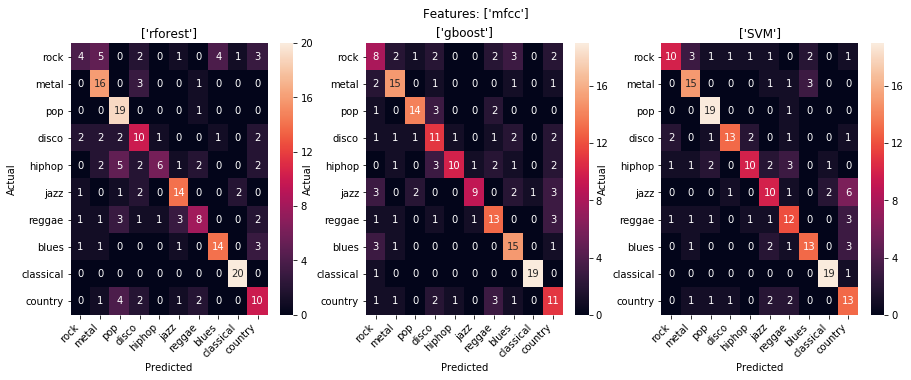

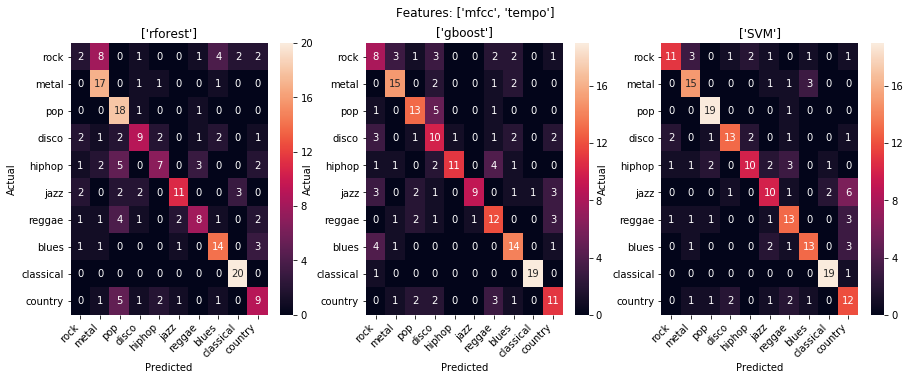

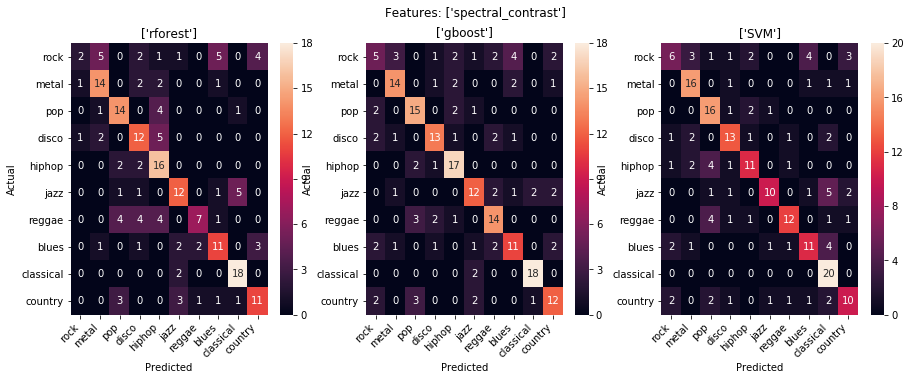

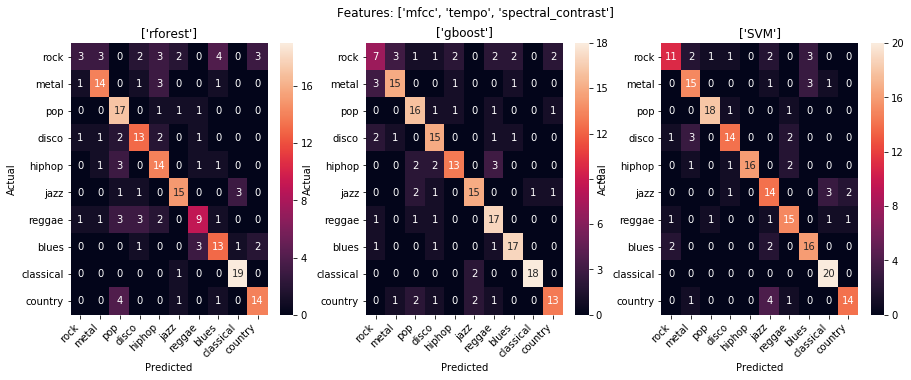

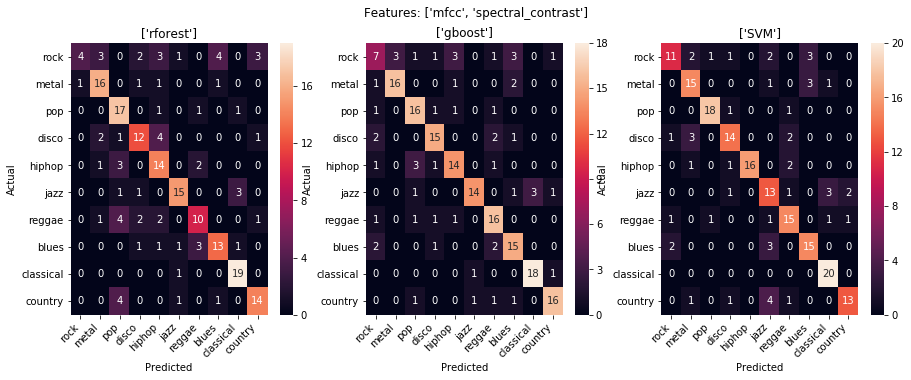

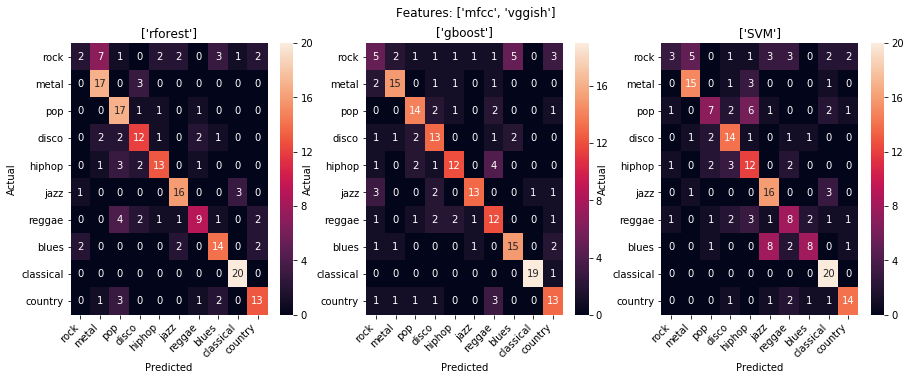

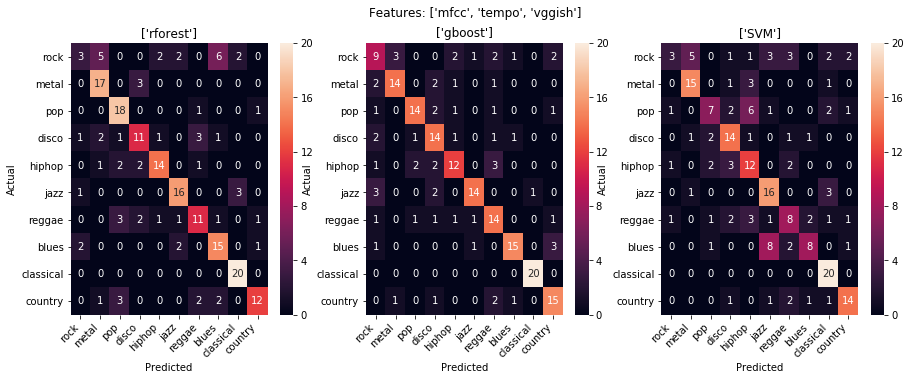

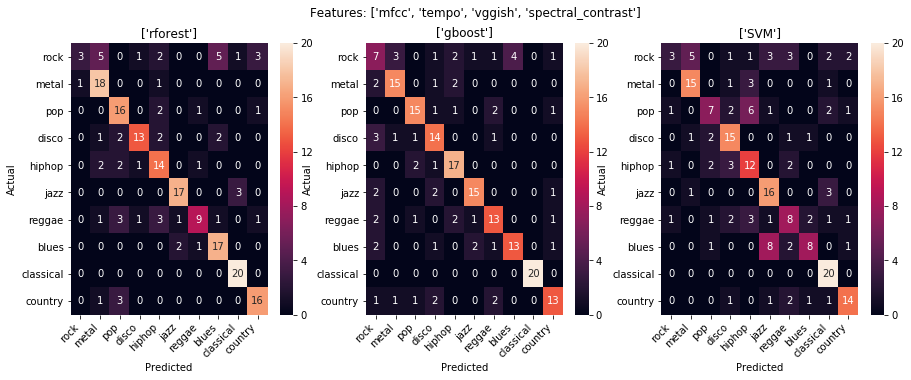

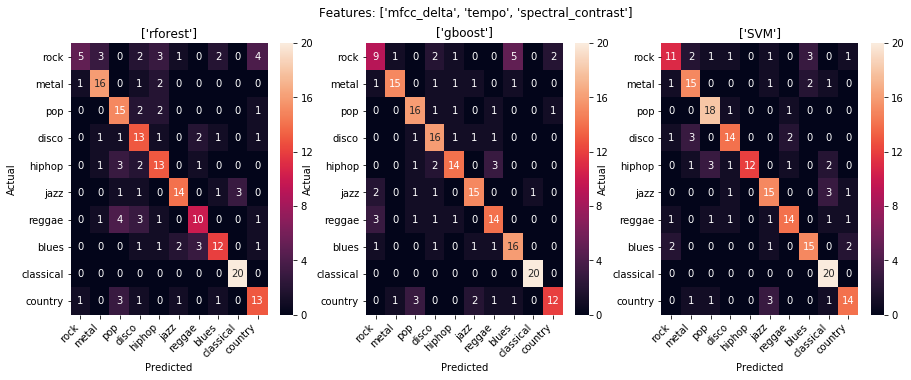

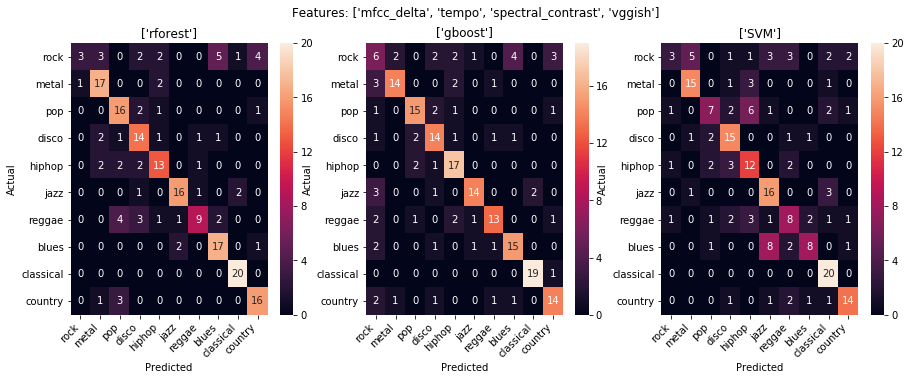

In [0]:
counter = 0
subcounter = 0;
headers = [];
table_list = [];
for i in reports.keys():      
  table = pd.DataFrame.from_dict({
        'Accuracy':reports[i]['accuracy'],
        'Precision': reports[i]['macro avg']['precision'],
        'Recall': reports[i]['macro avg']['recall'],
        'F1-score': reports[i]['macro avg']['f1-score'],
  }, orient = 'index', columns =  [i.split('+')[0]]);
  if subcounter == 0:
    plt.figure(figsize=(15,5));
    plt.suptitle('Features: {0}\n'.format(list(combos.values())[counter]))
  
  plt.subplot(1,3,subcounter+1)
  plt.title([i.split('+')[0]])
  plot_confusion_matrix(confusion_matrices[i], y_labels)
  subcounter += 1;
  if subcounter == 3:
    subcounter = 0;
    counter+=1;